In [103]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hackarena-theme-2-multilingual-sarcasm-detection/train .csv
/kaggle/input/hackarena-theme-2-multilingual-sarcasm-detection/test.csv


In [104]:
import os
import re
import emoji
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Input, Attention, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

In [105]:
train_df = pd.read_csv("/kaggle/input/hackarena-theme-2-multilingual-sarcasm-detection/train .csv")  # Fixed space in filename
test_df = pd.read_csv("/kaggle/input/hackarena-theme-2-multilingual-sarcasm-detection/test.csv")
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)


Train shape: (9840, 3)
Test shape: (2109, 3)


In [106]:
def handle_emojis(text):
    # convert emojis → textual representation (keeps sarcasm cues)
    return emoji.demojize(str(text), delimiters=(" ", " "))

def clean_text(text):
    text = str(text).lower()

    # remove URLs and mentions
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#", "", text)

    # keep Hindi, English, digits, basic punctuation, quotes & emojis
    # removed only unusual symbols
    text = re.sub(r"[^a-zA-Z0-9\u0900-\u097F\s.,!?\'\"…]", "", text)

    # collapse multiple spaces
    text = re.sub(r"\s+", " ", text).strip()

    return text

def preprocess_text(text):
    if pd.isna(text) or text.strip() == "":
        return ""
    text = handle_emojis(text)
    text = clean_text(text)
    return text

# Apply to dataset
train_df["Tweet"] = train_df["Tweet"].apply(preprocess_text)
test_df["Tweet"] = test_df["Tweet"].apply(preprocess_text)


In [107]:
# Label encoding
label_encoder = LabelEncoder()
train_df["Label"] = label_encoder.fit_transform(train_df["Label"])
test_df["Label"] = label_encoder.transform(test_df["Label"])
print("Label mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

Label mapping: {'NO': 0, 'YES': 1}


In [108]:
# Train/Val split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df["Tweet"], train_df["Label"],
    test_size=0.2,
    random_state=42,
    stratify=train_df["Label"]
)


In [109]:
# ============================
# Tokenization & Padding
# ============================
MAX_NUM_WORDS = 50000
MAX_SEQ_LEN = 50
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)
X_train = pad_sequences(tokenizer.texts_to_sequences(train_texts), maxlen=MAX_SEQ_LEN, padding="post")
X_val = pad_sequences(tokenizer.texts_to_sequences(val_texts), maxlen=MAX_SEQ_LEN, padding="post")
X_test = pad_sequences(tokenizer.texts_to_sequences(test_df["Tweet"]), maxlen=MAX_SEQ_LEN, padding="post")
y_train, y_val, y_test = train_labels.values, val_labels.values, test_df["Label"].values
print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)


Train: (7872, 50) (7872,)
Val: (1968, 50) (1968,)
Test: (2109, 50) (2109,)


In [110]:
# Embeddings (Hindi fastText for Hinglish - Best for Hindi-English Mix)
# ============================
!pip install fasttext
import fasttext
import fasttext.util
# Download and load Hindi fastText model (300D, covers Hindi + some English for Hinglish)
fasttext.util.download_model('hi', if_exists='ignore')  # Downloads cc.hi.300.bin (~1GB)
ft_model = fasttext.load_model('cc.hi.300.bin')


In [111]:
# Build embeddings index from the model
embeddings_index = {}
words = ft_model.get_words()
for word in words:
    embeddings_index[word] = ft_model.get_word_vector(word)
print("Total embeddings loaded:", len(embeddings_index))
# Build embedding matrix
word_index = tokenizer.word_index
embedding_dim = 300
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if i < MAX_NUM_WORDS:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        else:
            embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))  # Random for OOV
print("Embedding matrix shape:", embedding_matrix.shape)

Total embeddings loaded: 1876665
Embedding matrix shape: (22091, 300)


In [112]:


# ============================
# Custom Attention Layer (Corrected)
# ============================
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        self.att_dense = Dense(1, activation='tanh')   # ✅ create layer ONCE

    def call(self, inputs):
        # inputs: (batch, seq_len, hidden_dim)
        score = self.att_dense(inputs)                 # (batch, seq_len, 1)
        score = tf.squeeze(score, axis=-1)             # (batch, seq_len)

        # attention weights
        weights = tf.nn.softmax(score, axis=-1)        # (batch, seq_len)
        weights = tf.expand_dims(weights, axis=-1)     # (batch, seq_len, 1)

        # context vector (weighted sum)
        weighted_output = inputs * weights
        context_vector = tf.reduce_sum(weighted_output, axis=1)  # (batch, hidden_dim)

        return context_vector


# ============================
# Model Definition
# ============================
input_layer = Input(shape=(MAX_SEQ_LEN,))

embedding_layer = Embedding(
    input_dim=embedding_matrix.shape[0],
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=MAX_SEQ_LEN,
    trainable=False
)(input_layer)

bi_lstm1 = Bidirectional(LSTM(128, return_sequences=True))(embedding_layer)
drop1 = Dropout(0.4)(bi_lstm1)

bi_lstm2 = Bidirectional(LSTM(64, return_sequences=True))(drop1)
drop2 = Dropout(0.4)(bi_lstm2)

# Attention applied on the second BiLSTM
attention_output = AttentionLayer()(bi_lstm2)

dense1 = Dense(128, activation="relu")(attention_output)
drop3 = Dropout(0.3)(dense1)

output = Dense(1, activation="sigmoid")(drop3)

model = Model(inputs=input_layer, outputs=output)


# ============================
# Compile Model
# ============================
model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["accuracy"]
)

model.summary()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_11 (Embedding)        │ (None, 50, 300)        │     6,627,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_22                │ (None, 50, 256)        │       439,296 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 50, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_23                │ (None, 50, 128)        │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer_5               │ (None, 128)            │           129 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,247,718 (27.65 MB)

 Trainable params: 620,418 (2.37 MB)

 Non-trainable params: 6,627,300 (25.28 MB)

In [113]:

# ============================
# Class Weights
# ============================
class_weights_arr = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights_arr))


# ============================
# Callbacks
# ============================
early_stop = EarlyStopping(
    monitor="val_loss", patience=4, restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    "best_bilstm_attention.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    verbose=1
)


# ============================
# Training
# ============================
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint, reduce_lr],
    verbose=1
)


Epoch 1/20
121/123 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8883 - loss: 0.3364
Epoch 1: val_accuracy improved from -inf to 0.92886, saving model to best_bilstm_attention.h5


123/123 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.8889 - loss: 0.3343 - val_accuracy: 0.9289 - val_loss: 0.2092 - learning_rate: 0.0010
Epoch 2/20
121/123 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9366 - loss: 0.1625
Epoch 2: val_accuracy did not improve from 0.92886
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9365 - loss: 0.1627 - val_accuracy: 0.9192 - val_loss: 0.2288 - learning_rate: 0.0010
Epoch 3/20
121/123 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9421 - loss: 0.1475
Epoch 3: val_accuracy improved from 0.92886 to 0.94055, saving model to best_bilstm_attention.h5


123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9421 - loss: 0.1475 - val_accuracy: 0.9405 - val_loss: 0.1970 - learning_rate: 0.0010
Epoch 4/20
121/123 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9524 - loss: 0.1225
Epoch 4: val_accuracy did not improve from 0.94055
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9524 - loss: 0.1226 - val_accuracy: 0.9380 - val_loss: 0.1883 - learning_rate: 0.0010
Epoch 5/20
121/123 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9608 - loss: 0.1083
Epoch 5: val_accuracy improved from 0.94055 to 0.94715, saving model to best_bilstm_attention.h5


123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9607 - loss: 0.1084 - val_accuracy: 0.9472 - val_loss: 0.1648 - learning_rate: 0.0010
Epoch 6/20
121/123 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9675 - loss: 0.0884
Epoch 6: val_accuracy did not improve from 0.94715
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9674 - loss: 0.0885 - val_accuracy: 0.9370 - val_loss: 0.2145 - learning_rate: 0.0010
Epoch 7/20
121/123 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9726 - loss: 0.0728
Epoch 7: val_accuracy did not improve from 0.94715

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9726 - loss: 0.0730 - val_accuracy: 0.9299 - val_loss: 0.2223 - learning_rate: 0.0010
Epoch 8/20
121/123 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9756 - loss: 0.0639
Epoch 8: val_accuracy did not improve from 0.94715
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9757 - loss: 0.0638 - val_a

In [114]:
# ============================
# Evaluation
# ============================

from tensorflow.keras.models import load_model

# Load model with custom AttentionLayer
best_model = load_model(
    "best_bilstm_attention.h5",
    custom_objects={"AttentionLayer": AttentionLayer}
)

# Evaluate validation & test sets
val_loss, val_acc = best_model.evaluate(X_val, y_val, verbose=0)
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=0)

print(f"Validation Accuracy: {val_acc:.4f}, Validation Loss: {val_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")
def predict_sarcasm(text):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=MAX_SEQ_LEN)

    prob = best_model.predict(padded)[0][0]
    pred = int(prob > 0.5)

    label_map = {0: "non-sarcastic", 1: "sarcastic"}

    print(f"\nText: {text}")
    print(f"Predicted: {label_map[pred]} (prob={prob:.4f})")


# Predictions
y_pred_val = (best_model.predict(X_val) > 0.5).astype(int).flatten()
y_pred_test = (best_model.predict(X_test) > 0.5).astype(int).flatten()

# Classification report
from sklearn.metrics import classification_report

print("Validation Classification Report:")
print(classification_report(y_val, y_pred_val, target_names=label_encoder.classes_))

print("Test Classification Report:")
print(classification_report(y_test, y_pred_test, target_names=label_encoder.classes_))


Validation Accuracy: 0.9472, Validation Loss: 0.1648
Test Accuracy: 0.9474, Test Loss: 0.1714
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Validation Classification Report:
              precision    recall  f1-score   support

          NO       0.89      0.96      0.93       669
         YES       0.98      0.94      0.96      1299

    accuracy                           0.95      1968
   macro avg       0.94      0.95      0.94      1968
weighted avg       0.95      0.95      0.95      1968

Test Classification Report:
              precision    recall  f1-score   support

          NO       0.88      0.97      0.92       706
         YES       0.98      0.94      0.96      1403

    accuracy                           0.95      2109
   macro avg       0.93      0.95      0.94      2109
weighted avg       0.95      0.95      0.95      2109



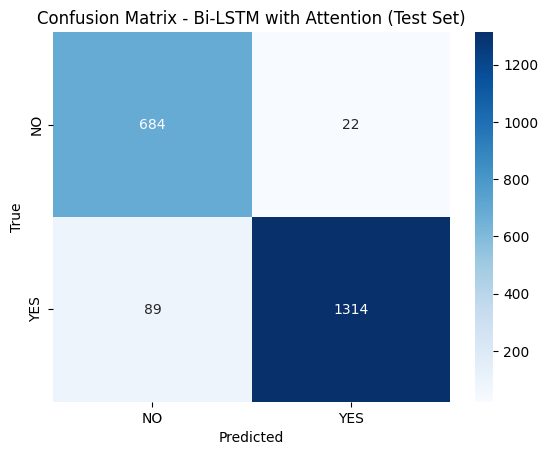

In [115]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Bi-LSTM with Attention (Test Set)")
plt.show()


In [116]:
# ROC-AUC
try:
    auc_val = roc_auc_score(y_val, best_model.predict(X_val).flatten())
    auc_test = roc_auc_score(y_test, best_model.predict(X_test).flatten())
    print(f"Validation AUC: {auc_val:.4f}, Test AUC: {auc_test:.4f}")
except:
    print("AUC calculation skipped (binary issue).")


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Validation AUC: 0.9797, Test AUC: 0.9803


In [117]:
# Example Predictions
# ============================
test_sentences = [
    "Wah, kya baat hai! Aur traffic jam chahiye tha, zindagi already bohot smooth chal rahi thi.",  # sarcastic
    "Traffic thoda zyada hai aaj, isliye main thoda late ho jaunga"  # non-sarcastic
]
test_cleaned = [preprocess_text(t) for t in test_sentences]  # Use full preprocess
test_seq = tokenizer.texts_to_sequences(test_cleaned)
test_pad = pad_sequences(test_seq, maxlen=MAX_SEQ_LEN, padding="post")
pred_probs = best_model.predict(test_pad)
pred_classes = (pred_probs > 0.5).astype(int).flatten()
label_map = {0: "non-sarcastic", 1: "sarcastic"}

for txt, prob, cls in zip(test_sentences, pred_probs, pred_classes):
    print(f"\nText: {txt}")
    print(f"Predicted: {label_map[cls]} (prob={prob[0]:.4f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

Text: Wah, kya baat hai! Aur traffic jam chahiye tha, zindagi already bohot smooth chal rahi thi.
Predicted: non-sarcastic (prob=0.2029)

Text: Traffic thoda zyada hai aaj, isliye main thoda late ho jaunga
Predicted: sarcastic (prob=0.5882)



Training Logistic Regression...

Logistic Regression Results:
Validation Accuracy: 0.9670
Test Accuracy: 0.9635

Classification Report:
              precision    recall  f1-score   support

          NO       0.93      0.97      0.95       706
         YES       0.98      0.96      0.97      1403

    accuracy                           0.96      2109
   macro avg       0.95      0.96      0.96      2109
weighted avg       0.96      0.96      0.96      2109



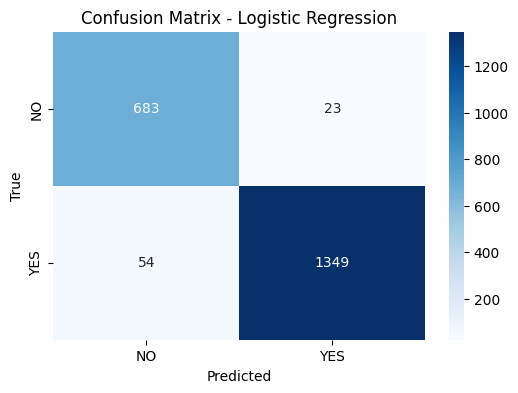


Training SVM (LinearSVC)...

SVM (LinearSVC) Results:
Validation Accuracy: 0.9741
Test Accuracy: 0.9730

Classification Report:
              precision    recall  f1-score   support

          NO       0.95      0.97      0.96       706
         YES       0.98      0.98      0.98      1403

    accuracy                           0.97      2109
   macro avg       0.97      0.97      0.97      2109
weighted avg       0.97      0.97      0.97      2109



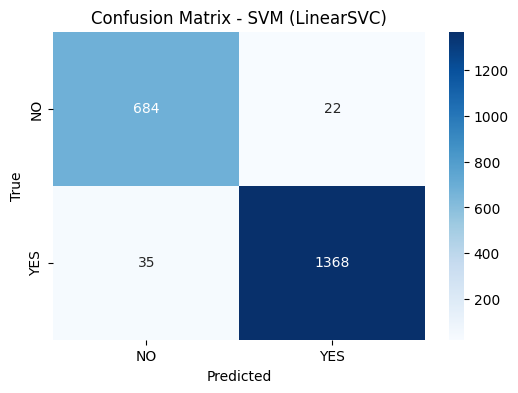


Training XGBoost...

XGBoost Results:
Validation Accuracy: 0.9746
Test Accuracy: 0.9734

Classification Report:
              precision    recall  f1-score   support

          NO       0.96      0.96      0.96       706
         YES       0.98      0.98      0.98      1403

    accuracy                           0.97      2109
   macro avg       0.97      0.97      0.97      2109
weighted avg       0.97      0.97      0.97      2109



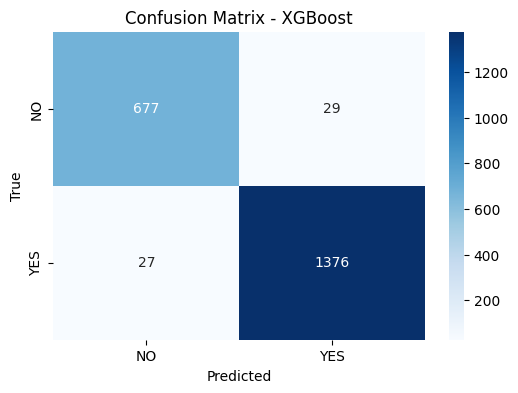


Training Naive Bayes...

Naive Bayes Results:
Validation Accuracy: 0.9614
Test Accuracy: 0.9630

Classification Report:
              precision    recall  f1-score   support

          NO       0.91      0.99      0.95       706
         YES       0.99      0.95      0.97      1403

    accuracy                           0.96      2109
   macro avg       0.95      0.97      0.96      2109
weighted avg       0.97      0.96      0.96      2109



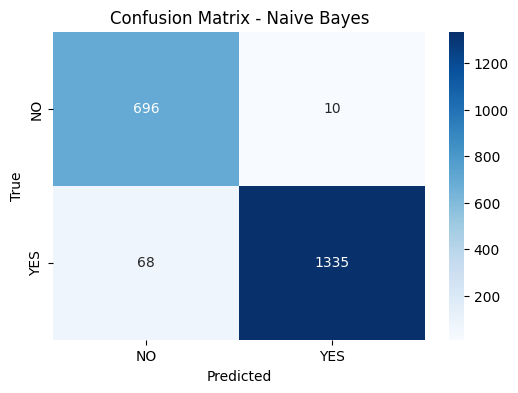


Training LightGBM...
[LightGBM] [Info] Number of positive: 5196, number of negative: 2676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19356
[LightGBM] [Info] Number of data points in the train set: 7872, number of used features: 770
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000

LightGBM Results:
Validation Accuracy: 0.9731
Test Accuracy: 0.9763

Classification Report:
              precision    recall  f1-score   support

          NO       0.96      0.97      0.96       706
         YES       0.98      0.98      0.98      1403

    accuracy                           0.98      2109
   macro avg       0.97      0.97      0.97      2109
weighted avg       0.98      0.98      0.98      2109



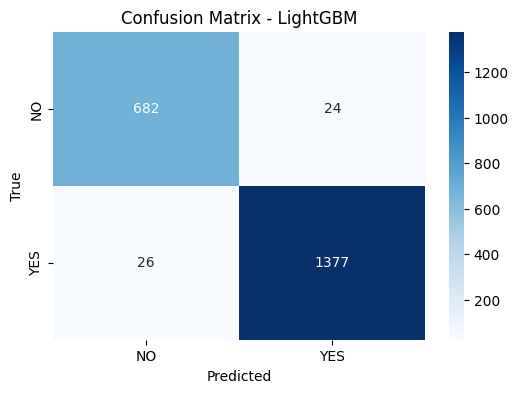


Training Random Forest...

Random Forest Results:
Validation Accuracy: 0.9593
Test Accuracy: 0.9540

Classification Report:
              precision    recall  f1-score   support

          NO       0.92      0.94      0.93       706
         YES       0.97      0.96      0.97      1403

    accuracy                           0.95      2109
   macro avg       0.95      0.95      0.95      2109
weighted avg       0.95      0.95      0.95      2109



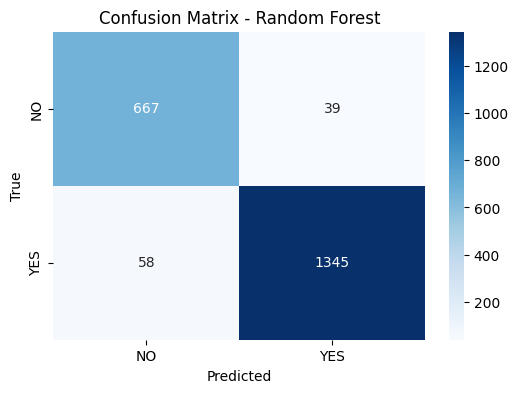

In [118]:
# ============================
# Baseline Models (4 total)
# ============================
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# TF-IDF Features
vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(train_texts)
X_val_tfidf = vectorizer.transform(val_texts)
X_test_tfidf = vectorizer.transform(test_df["Tweet"])

# Baseline models
models = {
    'Logistic Regression': LogisticRegression(max_iter=500, class_weight="balanced", random_state=42),
    'SVM (LinearSVC)': LinearSVC(class_weight="balanced", random_state=42),
    'XGBoost': XGBClassifier(n_estimators=300,learning_rate=0.05,max_depth=8,subsample=0.9,colsample_bytree=0.9,objective="binary:logistic",eval_metric="logloss",scale_pos_weight=1.0),
    'Naive Bayes': MultinomialNB(),
    'LightGBM' : LGBMClassifier(n_estimators=300,max_depth=-1,learning_rate=0.05,class_weight="balanced"),
    'Random Forest': RandomForestClassifier(
        n_estimators=200, 
        class_weight="balanced", 
        max_depth=40,
        random_state=42
    )
}

results = {}

for name, clf in models.items():
    print("\n========================================")
    print(f"Training {name}...")
    clf.fit(X_train_tfidf, y_train)

    val_acc = clf.score(X_val_tfidf, y_val)
    test_acc = clf.score(X_test_tfidf, y_test)

    results[name] = {"val_acc": val_acc, "test_acc": test_acc}

    print(f"\n{name} Results:")
    print(f"Validation Accuracy: {val_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")

    # Classification Report
    y_test_pred = clf.predict(X_test_tfidf)
    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

    # Confusion Matrix
    plt.figure(figsize=(6,4))
    cm = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


In [119]:
# ============================
# Show Best Model
# ============================

# Convert to DataFrame for easy sorting
results_df = pd.DataFrame(results).T  # transpose for better formatting
results_df = results_df.sort_values(by="test_acc", ascending=False)

print("\n============================")
print("📌 Model Performance Summary")
print("============================\n")
print(results_df)

# Best model
best_model_name = results_df.index[0]
best_val = results_df.iloc[0]["val_acc"]
best_test = results_df.iloc[0]["test_acc"]

print("\n============================")
print("🏆 Best Model")
print("============================")
print(f"Model: {best_model_name}")
print(f"Validation Accuracy: {best_val:.4f}")
print(f"Test Accuracy: {best_test:.4f}")



📌 Model Performance Summary

                      val_acc  test_acc
LightGBM             0.973069  0.976292
XGBoost              0.974593  0.973447
SVM (LinearSVC)      0.974085  0.972973
Logistic Regression  0.966972  0.963490
Naive Bayes          0.961382  0.963016
Random Forest        0.959350  0.954007

🏆 Best Model
Model: LightGBM
Validation Accuracy: 0.9731
Test Accuracy: 0.9763


In [121]:
# Reload model (IMPORTANT FIX)
best_model = load_model(
    "best_bilstm_attention.h5",
    custom_objects={"AttentionLayer": AttentionLayer}
)

# ============================
# User Input Sarcasm Predictor
# ============================

def predict_user_input():
    print("\nType a sentence to check sarcasm (or type 'exit' to stop):\n")
    
    while True:
        user_text = input("Enter text: ")

        if user_text.lower().strip() == "exit":
            print("Exiting prediction...")
            break

        # Preprocess text
        cleaned = preprocess_text(user_text)
        seq = tokenizer.texts_to_sequences([cleaned])
        padded = pad_sequences(seq, maxlen=MAX_SEQ_LEN)

        # Predict
        prob = best_model.predict(padded)[0][0]
        pred = int(prob > 0.5)

        label_map = {0: "non-sarcastic", 1: "sarcastic"}

        print(f"\nSentence: {user_text}")
        print(f"Predicted: {label_map[pred]} (prob={prob:.4f})\n")

# Run it
predict_user_input()



Type a sentence to check sarcasm (or type 'exit' to stop):



Enter text:  “Tum toh multitasking ke king ho—kaam bhi nahi karte, aur phir bhi thakte ho.”


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step

Sentence: “Tum toh multitasking ke king ho—kaam bhi nahi karte, aur phir bhi thakte ho.”
Predicted: non-sarcastic (prob=0.0020)



Enter text:  “Thanks for nothing… literally.”


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

Sentence: “Thanks for nothing… literally.”
Predicted: sarcastic (prob=0.9839)



Enter text:  “Bilkul sahi, kyunki galti toh tumse kabhi hoti hi nahi na?”


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

Sentence: “Bilkul sahi, kyunki galti toh tumse kabhi hoti hi nahi na?”
Predicted: non-sarcastic (prob=0.0016)



Enter text:  “Wah yaar, tumhari explanation sunke toh aur zyada confuse ho gaya main.”


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

Sentence: “Wah yaar, tumhari explanation sunke toh aur zyada confuse ho gaya main.”
Predicted: non-sarcastic (prob=0.0012)



Enter text:  “Aaj tumne bohot achha kaam kiya, appreciate karta hoon.”


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

Sentence: “Aaj tumne bohot achha kaam kiya, appreciate karta hoon.”
Predicted: non-sarcastic (prob=0.0012)



Enter text:  Haan haan, tumhare bina toh wifi bhi connect nahi hota hoga.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

Sentence: Haan haan, tumhare bina toh wifi bhi connect nahi hota hoga.
Predicted: non-sarcastic (prob=0.0012)



Enter text:  “Great! Ek aur brilliant idea, jiska koi matlab hi nahi.”


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

Sentence: “Great! Ek aur brilliant idea, jiska koi matlab hi nahi.”
Predicted: non-sarcastic (prob=0.0017)



Enter text:  exit


Exiting prediction...


In [126]:
# ============================
# Save Model
# ============================

# Save model with custom layer
best_model.save(
    "best_bilstm_attention.h5",
    include_optimizer=True
)

print("Model saved successfully!")


Model saved successfully!


In [128]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

# Load model with custom layer
best_model = load_model(
    "best_bilstm_attention.h5",
    custom_objects={"AttentionLayer": AttentionLayer}
)


In [129]:
MAX_SEQ_LEN = 100  # Use your training value


In [130]:
def predict_sarcasm(text, threshold=0.5):
    # Convert text to sequence
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=MAX_SEQ_LEN)

    # Predict probability
    prob = best_model.predict(padded)[0][0]

    # Convert to label
    pred = int(prob > threshold)
    label_map = {0: "non-sarcastic", 1: "sarcastic"}

    print("===============================")
    print("Input Text:", text)
    print("Prediction:", label_map[pred])
    print("Probability:", prob)
    print("===============================")

    return pred, prob


In [133]:
MAX_SEQ_LEN = 50   # must match training

def predict_sarcasm(text, threshold=0.5):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=MAX_SEQ_LEN)

    prob = best_model.predict(padded)[0][0]

    pred = int(prob > threshold)
    label_map = {0: "non-sarcastic", 1: "sarcastic"}

    print("===============================")
    print("Input:", text)
    print("Prediction:", label_map[pred])
    print("Probability:", prob)
    print("===============================")

    return pred, prob
